In [1]:
#Test notebook for tracking rigid body  marker consisting of multiple fiducials within a CT scan volume

#3D data processing
import open3d as o3d
import ct_tracking_library # our helper functions
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
from ipywidgets import interact, fixed

#our processing code
from ct_tracking_library.ct_motor_functions import *
from ct_tracking_library.ct_tracking_functions import *
from ct_tracking_library.ct_processing_functions import *
from ct_tracking_library.ct_display_functions import *
from ct_tracking_library.ct_object_classes import *

#used for GUI
%matplotlib notebook

#find transform
import transforms3d as t3d
import datetime
import time
import pickle
from spatialmath import *
from roboticstoolbox import ET as E

In [2]:
with open('data.pkl', 'rb') as f:
    data_load = pickle.load(f)

<IPython.core.display.Javascript object>


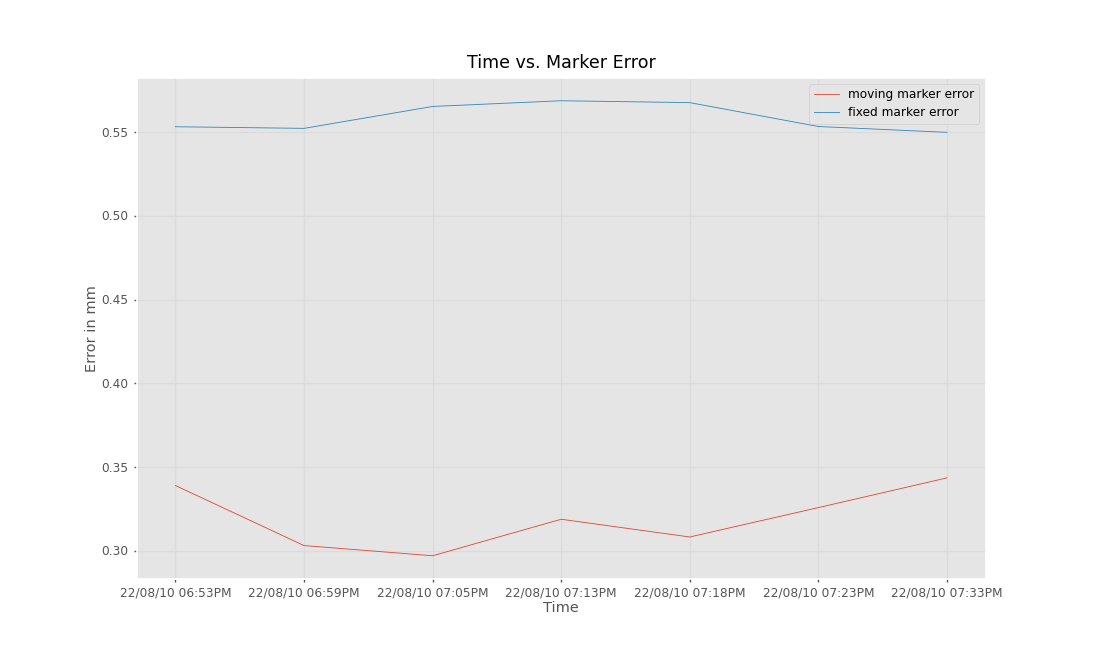

In [69]:
Me_list = []
Fe_list = []
TT_list = []
for x in data_load:
        Me_list.append(data_load[x][0].error)
        Fe_list.append(data_load[x][1].error)
        TT_list.append(data_load[x][0].time)
plt.plot(TT_list,Me_list)
plt.plot(TT_list,Fe_list)
plt.ylabel('Error in mm')
plt.xlabel('Time')
plt.legend(["moving marker error","fixed marker error"])
plt.title("Time vs. Marker Error")
plt.show()

In [ ]:
Tbase = SE3(data_load['scan6'][1].T)
Tee = SE3(data_load['scan6'][0].T)

### loaded data back to open3d to check

In [70]:
marker = np.array([[0,-14,0],[0,-6,0],[0,16,0],[17,0,0]])
R = np.eye(3)
crop_z = [160,254]
_, marker_centroid_coordinates, pcd_selected, marker_mesh, _, good_centroid_clusters = find_candidate_centroids(marker = marker, debug=False)
#find best transform and marker from candidate fiducials
tracked_R, tracked_t, permuted_centroids, min_error = find_best_transform_from_candidate_marker_clusters(marker, good_centroid_clusters)

#get rid of column of ones to make 3xN
permuted_centroids = permuted_centroids[:3,:].T

#transform marker geometry coordinates using found transform to tracked image coordinates
transformed_marker = (tracked_R @ marker.T + tracked_t).T
error = permuted_centroids-transformed_marker

[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=22
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 8


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]C:\Users\derek\Documents\GitHub\ct-fiducial-tracking\ct_tracking_library\ct_tracking_functions.py:420: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C, residules, rank, singval = np.linalg.lstsq(A,f)
100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 137.94it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
[0.15121875 5.78646056]
Everything looks good!
the final error is:  0.15121874801590013


In [ ]:
Tr = tracked_R
Tt = tracked_t

In [71]:
Tr = Tbase.R
Tt = Tbase.t.reshape((3,1))*1000

In [72]:
#create o3d visualizations
marker_3d_tracked = create_marker_visualization(fiducial_coordinates=permuted_centroids, color=[0.8, 0.2, 0.2])
marker_3d_base = create_marker_visualization(marker, [0.2, 0.8, 0.2])
marker_3d_base.append(create_coordinate_frame_visualization())
marker_3d_transformed = create_marker_visualization(marker, [0.2, 0.2, 0.8], Tr, Tt)
marker_3d_transformed.append(create_coordinate_frame_visualization(Tr, Tt))

#display tracked  markers and coordinate frames
# o3d.visualization.draw_geometries(marker_3d_tracked)
# o3d.visualization.draw_geometries(marker_3d_base)
# o3d.visualization.draw_geometries(marker_3d_transformed)

#tracking error from final transform
np.set_printoptions(2)
print("Error (mm): {}".format(error))
print("Error norm (mm): {}".format(np.linalg.norm(error)**0.5))

#visualize tracked markers on top of mesh used for tracking
visualization_list2 = marker_3d_tracked+marker_3d_base+marker_3d_transformed + [marker_mesh]
o3d.visualization.draw_geometries(visualization_list2)

Error (mm): [[-9.13e-02 -1.62e-01  1.14e-02]
 [ 1.33e-01 -2.73e-02 -2.83e-02]
 [-4.16e-02  1.89e-01 -2.88e-03]
 [ 1.33e-04  1.31e-04  1.98e-02]]
Error norm (mm): 0.5499431752752281


### FK compare

In [47]:
offset = data_load['scan0'][2].joint_postion

In [63]:
E_pos = []
E_norm = []

In [64]:
for x in data_load:
    Tbase = SE3(data_load[x][1].T)
    Tee = SE3(data_load[x][0].T)
    e = E.tx(-0.04009572)*E.ty(0.02163274)*E.tz(-0.01404157)*E.tz()
    e = e*E.Rx(90, 'deg')*E.Ry(-90, 'deg')
    Tfk = SE3(e.eval([(data_load[x][2].joint_postion-offset)/1000]))
    #print(data_load[x][2].joint_postion-offset)
    Tfinal = Tbase.inv()*Tee
    E_pos.append(Tfinal.t-Tfk.t)
    E_norm.append(np.linalg.norm(Tfinal.t-Tfk.t))

<IPython.core.display.Javascript object>


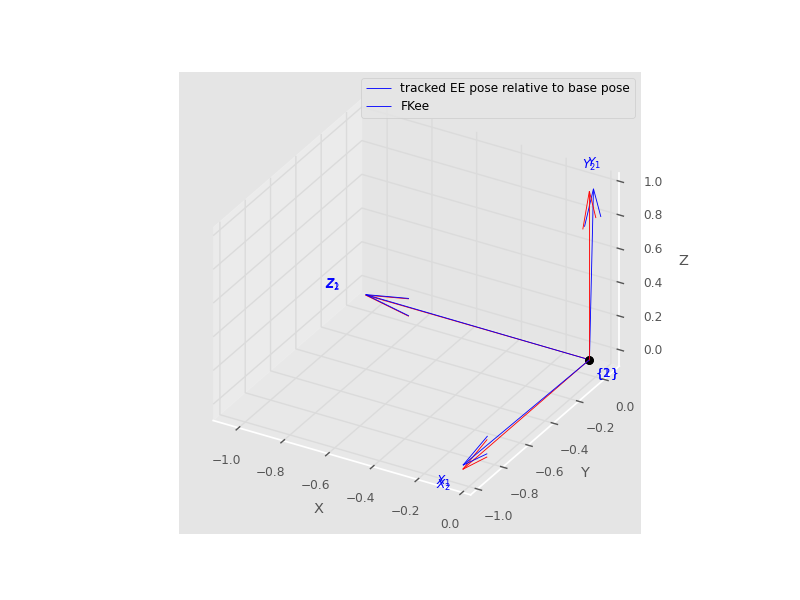

In [65]:
Tfinal.plot(frame='1',color='blue')
Tfk.plot(frame='2',color='red')
plt.legend(["tracked EE pose relative to base pose","FKee"])

<IPython.core.display.Javascript object>


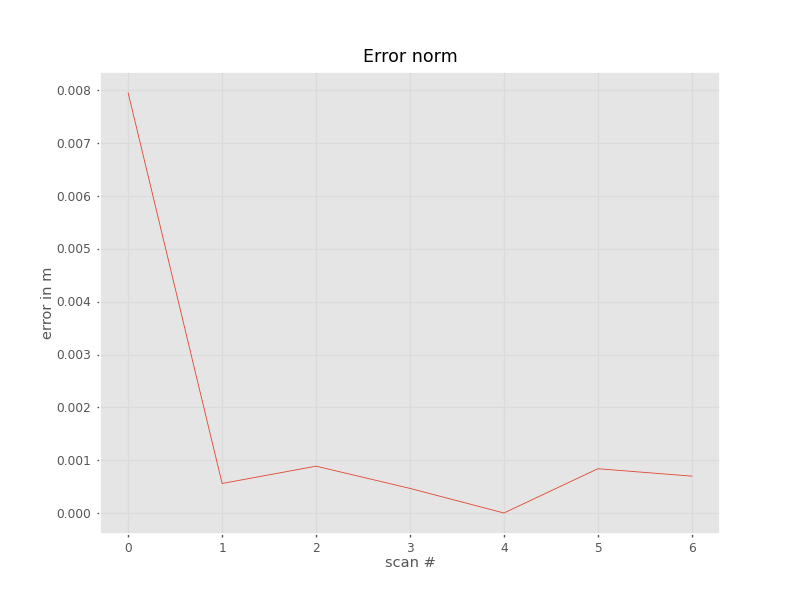

Text(0, 0.5, 'error in m')

In [66]:
plt.plot(E_norm)
plt.title("Error norm")
plt.xlabel("scan #")
plt.ylabel("error in m")

In [68]:
np.std(E_norm[1:])

0.00029563646060180664

In [62]:
E_pos

[array([-0.03947743,  0.02131157, -0.02196242]),
 array([-0.03980146,  0.02139926, -0.01445547]),
 array([-0.04077313,  0.02198552, -0.01359131]),
 array([-0.04043346,  0.02179144, -0.01376319]),
 array([-0.04009572,  0.02163274, -0.01404157]),
 array([-0.04081516,  0.02193786, -0.01373817]),
 array([-0.03946234,  0.0213518 , -0.0141261 ])]

In [ ]:
Tfinal.plot(frame='1',color='blue')
Tfk.plot(frame='2',color='red')
plt.legend(["tracked EE pose relative to base pose","FKee"])

In [41]:
e = E.tx(.04)*E.ty(-.024)*E.tz(.0235)*E.tz()
e = e*E.Rx(90, 'deg')*E.Ry(-90, 'deg')
i = 0

2.4283602729440515e-06


<IPython.core.display.Javascript object>


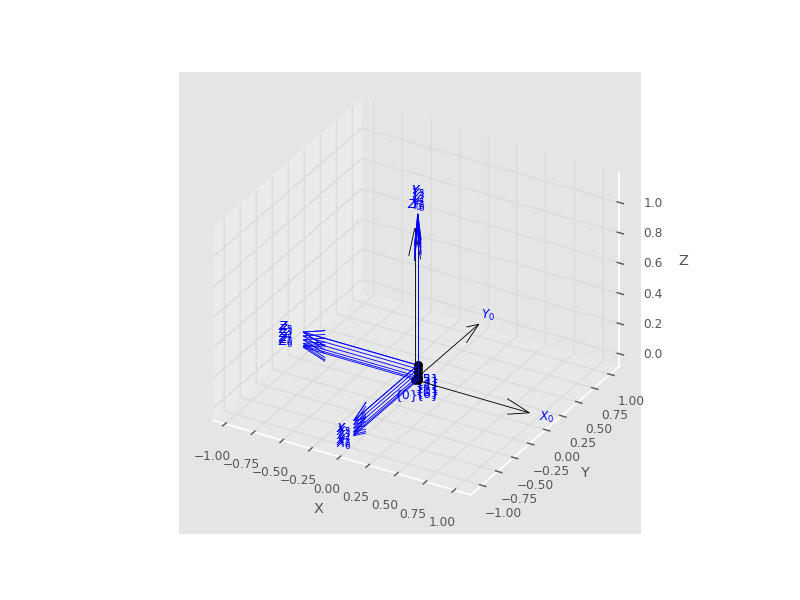

0.015028730778288963
0.09003664680244086
0.06500354480469671
0.04000646601437416
0.09002350892679298
-0.009993988059668961


In [42]:
for x in data_load:
    Tfk = SE3(e.eval([data_load[x][2].joint_postion/1000]))
    print(data_load[x][2].joint_postion/1000)
    Tfk.plot(frame=str(i))
    i += 1
SE3().plot(frame='0', color='black')

<IPython.core.display.Javascript object>


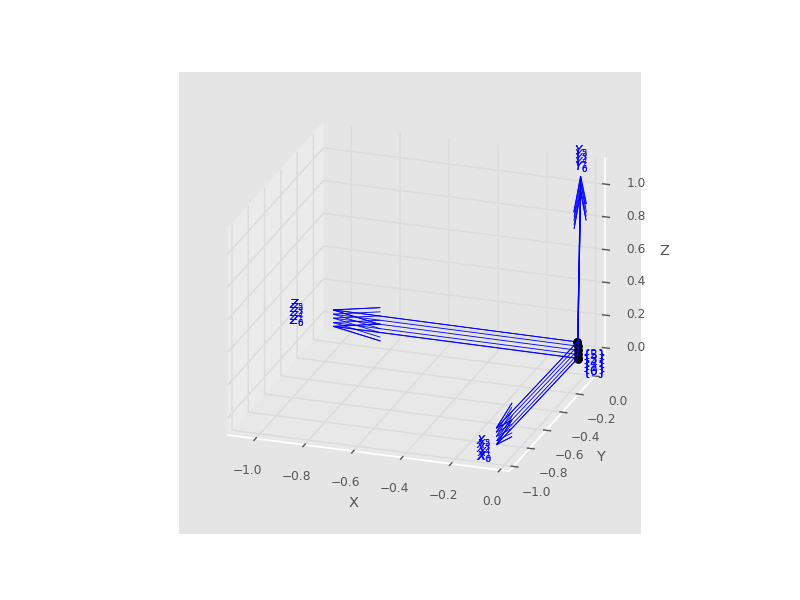

In [30]:
i = 0
for x in data_load:
    Tbase = SE3(data_load[x][1].T)
    Tee = SE3(data_load[x][0].T)
    Tfinal = Tbase.inv()*Tee
    #Tbase.plot(frame=str(i),color = 'red')
    #Tee.plot(frame=str(i),color = 'blue')
    Tfinal.plot(frame=str(i))
    i += 1

In [27]:
data_load['scan0']

[Marker(moving_marker_1_DoF:22/08/10 06:53PM),
 Marker(fixed_marker_1_DoF:22/08/10 06:53PM),
 Robot(22/08/10 06:53PM)]

<IPython.core.display.Javascript object>


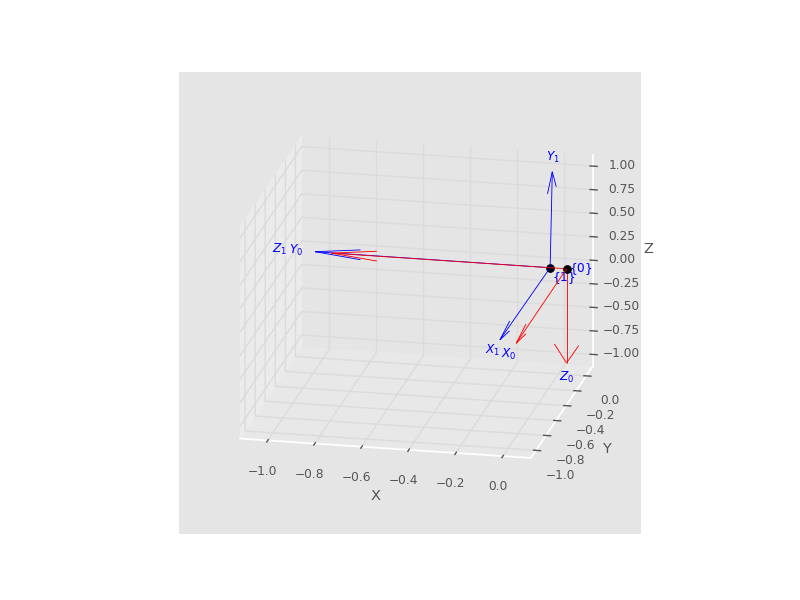

In [25]:
Tfk.plot(frame='0',color='red')
Tfinal.plot(frame='1',color='blue')

In [5]:
import roboticstoolbox as rtb

In [6]:
robot = rtb.ERobot(e)
print(robot)

ERobot: noname, 1 joints (P)
┌─────┬────────┬───────┬────────┬─────────────────────────────────────────────┐
│link │  link  │ joint │ parent │             ETS: parent to link             │
├─────┼────────┼───────┼────────┼─────────────────────────────────────────────┤
│   0 │ link0  │     0 │ BASE   │ tx(0.04) ⊕ ty(-0.024) ⊕ tz(0.0235) ⊕ tz(q0) │
│   1 │ @link1 │       │ link0  │ Ry(180°) ⊕ Rz(-90°)                         │
└─────┴────────┴───────┴────────┴─────────────────────────────────────────────┘



In [12]:
q = []
for x in data_load:
    q.append(data_load[x][2].joint_postion/1000)

In [13]:
q

[2.4283602729440515e-06,
 0.015028730778288963,
 0.09003664680244086,
 0.06500354480469671,
 0.04000646601437416,
 0.09002350892679298,
 -0.009993988059668961]

<IPython.core.display.Javascript object>


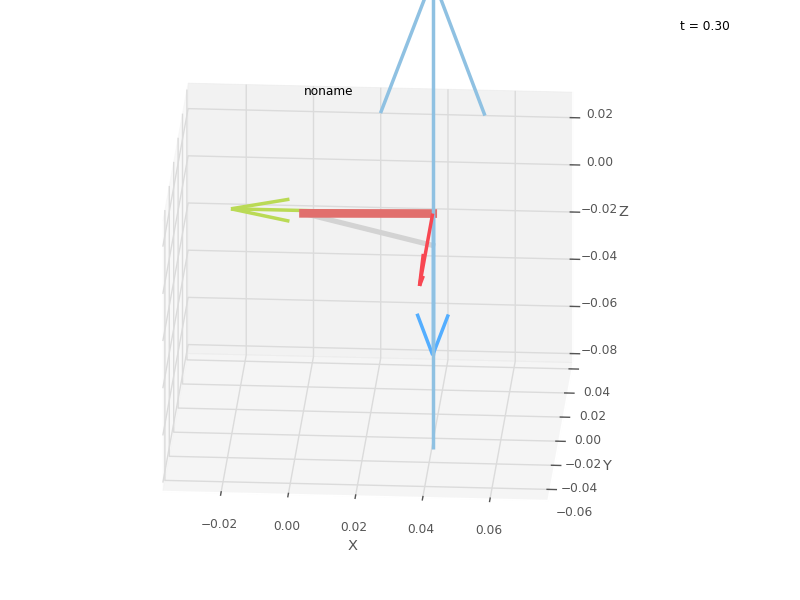

PyPlot3D backend, t = 0.35, scene:
  noname

In [14]:
robot.plot(q)

In [ ]:
qt = rtb.tools.trajectory.jtraj(q[1]/1000, q[2]/1000, 50)

In [ ]:
robot.plot(qt.q, dt=0.1);

In [ ]:
robot.fkine(q[1])